# Load data

In [1]:
import numpy as np
from sklearn.cluster import KMeans

fast_all_IND_test_activations = np.load("nighttime_ai_fast_model_fast_data_activations.npy")
fast_all_OOD_activations = np.load("nighttime_ai_fast_model_slow_data_activations.npy")
slow_all_IND_test_activations = np.load("nighttime_ai_slow_model_slow_data_activations.npy")
slow_all_OOD_activations = np.load("nighttime_ai_slow_model_fast_data_activations.npy")

[d.shape for d in
 (fast_all_IND_test_activations, fast_all_OOD_activations, slow_all_OOD_activations, slow_all_IND_test_activations)]

[(19250, 256), (20304, 256), (19250, 256), (20304, 256)]

# Find N for Kmeans

In [102]:
import matplotlib.pyplot as plt


def find_inertia(data):
    inertias = {}
    for n in range(2, 10):
        model = KMeans(n_clusters=n, random_state=0).fit(data)
        inertias[n] = model.inertia_
    return inertias


def find_N():
    d = dict()
    d['Fast model InD data'] = find_inertia(fast_all_IND_test_activations)
    d['Fast model OOD data'] = find_inertia(fast_all_OOD_activations)
    d['Slow model InD data'] = find_inertia(slow_all_IND_test_activations)
    d['Slow model OOD data'] = find_inertia(slow_all_OOD_activations)
    return d


d = find_N()

### Figure 16.
Finding the best number of clusters for K-means clustering method


65621.46171039359
27843.42405951348
85018.83980276232
20290.949789510305


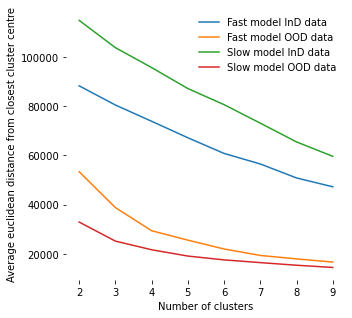

In [125]:
fig, ax = plt.subplots(figsize=(5, 5))

for name, dd in d.items():
    data = {k: v for k, v in dd.items()}
    average_inertia_over_samples = np.array(list(data.values())) / len(data.values())

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.plot(data.keys(), average_inertia_over_samples, label=name)
    ax.set(xlabel= "Number of clusters", ylabel = "Average euclidean distance from closest cluster centre")

    print(average_inertia_over_samples.mean())

plt.legend(frameon=False, loc="upper right")
plt.show()


# Clustering with N=3

In [5]:
fast_model_IND_train = fast_all_IND_test_activations[:9500, :]
fast_model_IND_test = fast_all_IND_test_activations[9500:9500 + 9500, :]
fast_model_IND_train.shape, fast_model_IND_test.shape

((9500, 256), (9500, 256))

In [6]:
slow_model_IND_train = slow_all_IND_test_activations[:9500]
slow_model_IND_test = slow_all_IND_test_activations[9500:9500 + 9500]
slow_model_IND_train.shape, slow_model_IND_test.shape

((9500, 256), (9500, 256))

In [4]:
import numpy as np


def cal_mahal_dist(x, y, for_cov):
    matrix_center = np.mean(y, axis=0)
    delta = x - matrix_center

    # calculate the covariance matrix and its inverse matrix
    cov_matrix = np.cov(for_cov, rowvar=False, ddof=1)
    cov_matrix_inv = np.linalg.pinv(cov_matrix)

    # calculate the Mahalanobis distance between a single vector and the center of the dataset
    def md_vector(vector):
        inner_prod = np.dot(vector, cov_matrix_inv)
        dist = np.sqrt(np.dot(inner_prod, vector))
        return dist

    mahal_dist = np.apply_along_axis(arr=delta, axis=1, func1d=md_vector)
    assert len(mahal_dist) == len(x)
    return mahal_dist


def mahalanobis(x, cluster_center, for_cov):
    """
    @param x: 2D array of the shape (nxm) n: samples, m: dimensions
    @param cluster_center: 1 D array with length m: dimensions
    @param for_cov: 2D array of the shape (nxm) n: samples, m: dimensions - used for covariance matrix
    @return: a 1D array of the length n which contains mahalanobis distance for each sample in x
    """
    assert len(x.shape) == 2
    assert len(cluster_center.shape) == 1
    assert x.shape[1] == cluster_center.shape[0]

    d = np.repeat(cluster_center.reshape(1, -1), len(x), axis=0)

    return cal_mahal_dist(x, d, for_cov)


# test my mahalanobis function

from scipy.spatial import distance

aaa = np.array([0, 1, 0])

x1 = [1, 0, 0]
x2 = [0, 2, 0]
x3 = [2, 0, 0]
x = np.array([x1, x2, x3])

cov_matrix = np.cov(x, rowvar=False, ddof=1)
cov_matrix_inv = np.linalg.pinv(cov_matrix)

[distance.mahalanobis(x1, aaa, cov_matrix_inv),
 distance.mahalanobis(x2, aaa, cov_matrix_inv),
 distance.mahalanobis(x3, aaa, cov_matrix_inv)
 ]

[0.9999999999999993, 1.7320508075688772, 2.6457513110645903]

## Figure 17.
ROC curve for InD and OOD Mahalanobis distances from K-means cluster centres.

AUROC for both datasets together

In [17]:
from sklearn.cluster import KMeans


def get_mahal_scores_from_kmeans_clusters(train, val, test):
    N = 3
    model = KMeans(n_clusters=N, random_state=0)
    model.fit(train)
    mahal_train = []
    mahal_test = []
    mahal_ood = []

    for cluster_center in model.cluster_centers_:
        mahal_train.append(mahalanobis(train, cluster_center, train))
        mahal_test.append(mahalanobis(val, cluster_center, train))
        mahal_ood.append(mahalanobis(test, cluster_center, train))

    mahal_train = np.min(np.array(mahal_train), axis=0).T
    mahal_test = np.min(np.array(mahal_test), axis=0).T
    mahal_ood = np.min(np.array(mahal_ood), axis=0).T

    return mahal_train, mahal_test, mahal_ood


mahal_train_fast, mahal_test_fast, mahal_ood_fast = get_mahal_scores_from_kmeans_clusters(fast_model_IND_train, fast_model_IND_test, fast_all_OOD_activations)

mahal_train_slow, mahal_test_slow, mahal_ood_slow = get_mahal_scores_from_kmeans_clusters(slow_model_IND_train, slow_model_IND_test, slow_all_OOD_activations)


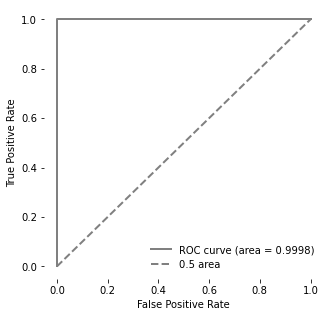

In [18]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

fast_IND_mahal = np.vstack([np.zeros(len(mahal_test_fast)), mahal_test_fast]).T
fast_OOD_mahal = np.vstack([np.ones(len(mahal_ood_fast)), mahal_ood_fast]).T
slow_IND_mahal = np.vstack([np.zeros(len(mahal_test_slow)), mahal_test_slow]).T
slow_OOD_mahal = np.vstack([np.ones(len(mahal_ood_slow)), mahal_ood_slow]).T
data = np.concatenate((fast_IND_mahal,
                       fast_OOD_mahal,
                       slow_IND_mahal,
                       slow_OOD_mahal))
y_true = data[:, 0]
y_score = data[:, 1]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(
    fpr,
    tpr,
    color="grey",
    lw=2,
    label="ROC curve (area = %0.4f)" % roc_auc,
)
ax.plot([0, 1], [0, 1], color="grey", lw=2, linestyle="--", label='0.5 area')
ax.set(xlabel= "False Positive Rate", ylabel = "True Positive Rate")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False, loc="lower right")
plt.show()


In [19]:

ddd = {
    'Train InD': mahal_train_fast,
    'Test InD': mahal_test_fast,
    'OOD': mahal_ood_fast,
}

print('Average Mahalanobis distance scores for fast model:')
for n, v in ddd.items():
    print(n, f'{v.mean():.1f}')

ddd = {
    'Train InD': mahal_train_slow,
    'Test InD': mahal_test_slow,
    'OOD': mahal_ood_slow,
}

print('Average Mahalanobis distance scores for slow model:')
for n, v in ddd.items():
    print(n, f'{v.mean():.1f}')


Average Mahalanobis distance scores for fast model:
Train InD 15.6
Test InD 16.2
OOD 100.4
Average Mahalanobis distance scores for slow model:
Train InD 15.7
Test InD 16.6
OOD 65.9


### 4.4.3 T-distributed Stochastic Neighbour Embedding

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(
    np.concatenate((fast_all_IND_test_activations, fast_all_OOD_activations)))


/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [21]:
labels = np.concatenate((np.zeros(len(fast_all_IND_test_activations)), np.ones(len(fast_all_OOD_activations))))
labels.shape

(39554,)

In [22]:
tsne.embedding_.shape

(39554, 3)

### Figure 18.
Fast model's t-SNE 3D plot viewed from three different angles.


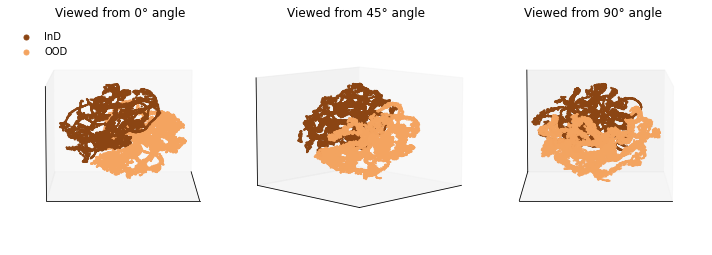

In [23]:
from matplotlib import ticker


def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, axs = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(10, 5),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.tight_layout()
    fig.suptitle(title, size=16)
    plot__(axs[0], points_color, x, y, z, 0)
    plot__(axs[1], points_color, x, y, z, 45)
    plot__(axs[2], points_color, x, y, z, 90)
    axs[0].legend(frameon=False, loc='upper left', prop={'size': 10}, markerscale=5)
    plt.show()


def plot__(ax, points_color, x, y, z, azim):
    ax.scatter(x[points_color==0], y[points_color==0], z[points_color==0], c='saddlebrown', s=1, label='InD')
    ax.scatter(x[points_color==1], y[points_color==1], z[points_color==1], c='sandybrown', s=1, label='OOD')
    ax.view_init(azim=azim, elev=9)
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.zaxis.set_major_locator(ticker.NullLocator())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    ax.set(xticks = [], yticks = [], zticks = [], title=f'Viewed from {azim}° angle')

plot_3d(tsne.embedding_, labels, None)